In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import scipy
from math import sqrt
import matplotlib.pyplot as plt

In [2]:
# Import utilities

# check scikit-learn version
import sklearn
print('sklearn: %s' % sklearn.__version__)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

sklearn: 0.21.2


In [3]:
# Define estimators to be used.  This time it is Regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [4]:
# Load input file
rawData = pd.read_csv('default of credit card clients.csv', header=1)

In [5]:
# Take a look at the data
rawData.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [6]:
# See what it is made of.
rawData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
ID           30000 non-null int64
LIMIT_BAL    30000 non-null int64
SEX          30000 non-null int64
EDUCATION    30000 non-null int64
MARRIAGE     30000 non-null int64
AGE          30000 non-null int64
PAY_0        30000 non-null int64
PAY_2        30000 non-null int64
PAY_3        30000 non-null int64
PAY_4        30000 non-null int64
PAY_5        30000 non-null int64
PAY_6        30000 non-null int64
BILL_AMT1    30000 non-null int64
BILL_AMT2    30000 non-null int64
BILL_AMT3    30000 non-null int64
BILL_AMT4    30000 non-null int64
BILL_AMT5    30000 non-null int64
BILL_AMT6    30000 non-null int64
PAY_AMT1     30000 non-null int64
PAY_AMT2     30000 non-null int64
PAY_AMT3     30000 non-null int64
PAY_AMT4     30000 non-null int64
PAY_AMT5     30000 non-null int64
PAY_AMT6     30000 non-null int64
DEFAULT      30000 non-null int64
dtypes: int64(25)
memory usage: 5.7 MB


In [9]:
# Preprocess the data file.  Drop unneeded attributes.
features = rawData.iloc[:,12:24]
print('Summary of feature sample')
features.head()

Summary of feature sample


,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,3913,3102,689,0,0,0,0,689,0,0,0,0
1,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679


In [10]:
#dependent variable
depVar = rawData['DEFAULT']
print(depVar)

0        1
1        1
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       1
14       0
15       0
16       1
17       0
18       0
19       0
20       0
21       1
22       1
23       1
24       0
25       0
26       1
27       0
28       0
29       0
        ..
29970    0
29971    0
29972    0
29973    1
29974    1
29975    0
29976    1
29977    0
29978    0
29979    0
29980    0
29981    0
29982    1
29983    0
29984    0
29985    0
29986    0
29987    0
29988    0
29989    0
29990    0
29991    1
29992    0
29993    0
29994    1
29995    0
29996    0
29997    1
29998    1
29999    1
Name: DEFAULT, Length: 30000, dtype: int64


In [11]:
#Training Set (Feature Space: X Training)
X_train = (features[: 21000])
X_train.head()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,3913,3102,689,0,0,0,0,689,0,0,0,0
1,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679


In [12]:
#Dependent Variable Training Set (y Training)
y_train = depVar[: 21000]
y_train_count = len(y_train.index)
print('The number of observations in the Y training set are:',str(y_train_count))
y_train.head()

The number of observations in the Y training set are: 21000


0    1
1    1
2    0
3    0
4    0
Name: DEFAULT, dtype: int64

In [13]:
#Testing Set (X Testing)
X_test = features[-9000:]
X_test_count = len(X_test.index)
print('The number of observations in the feature testing set is:',str(X_test_count))
print(X_test.head())

The number of observations in the feature testing set is: 9000
       BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  BILL_AMT6  \
21000          0        780          0       1170        780          0   
21001     178220     184848     188411     191291     189029     192023   
21002     128602     118109      21557      23186      14117      15797   
21003     160106     162743      81890          0          0          0   
21004      79237      65301      67253      67352      74448      72928   

       PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  
21000       780         0      1170         0         0         0  
21001     10000      9000      8000      6738      6974      7600  
21002      3203      6015      5055      2011      4078      4522  
21003      7600      4000         0         0         0         0  
21004      3000      4005      2500     10000         0      5000  


In [14]:
#Ground Truth (y_test) 
y_test = depVar[-9000:]
y_test_count = len(y_test.index)
print('The number of observations in the Y training set are:',str(y_test_count))
y_test.head()

The number of observations in the Y training set are: 9000


21000    0
21001    1
21002    0
21003    1
21004    1
Name: DEFAULT, dtype: int64

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train)
X_train.shape, X_test.shape

((15750, 12), (5250, 12))

In [16]:
#Models
modelSVC = SVC(gamma='scale')
modelRF = RandomForestClassifier(n_estimators=100)
modelDT = DecisionTreeClassifier()


In [17]:
#Model Fitting
modelRF.fit(X_train,y_train)
print(cross_val_score(modelRF, X_train, y_train, cv=5))
modelRF.score(X_train,y_train)

[0.78006982 0.77904762 0.77968254 0.7815873  0.78056526]


0.9871746031746031

In [18]:
modelSVC.fit(X_train,y_train)
print(cross_val_score(modelSVC, X_train, y_train, cv=5)) 
modelSVC.score(X_train,y_train)

[0.77086639 0.77079365 0.77111111 0.77079365 0.77135599]


0.7714920634920635

In [19]:
modelDT.fit(X_train,y_train)
print(cross_val_score(modelDT, X_train, y_train, cv=5)) 
modelDT.score(X_train,y_train)

[0.68708347 0.68730159 0.69174603 0.68666667 0.68339155]


0.9871746031746031

In [20]:
# Making RF predictions
predictions = modelRF.predict(X_test)
predRsquared = r2_score(y_test,predictions)
rmse = sqrt(mean_squared_error(y_test, predictions))
print('R Squared: %.3f' % predRsquared)
print('RMSE: %.3f' % rmse)

R Squared: -0.285
RMSE: 0.474


ValueError: 'c' argument has 2 elements, which is not acceptable for use with 'x' with size 5250, 'y' with size 5250.

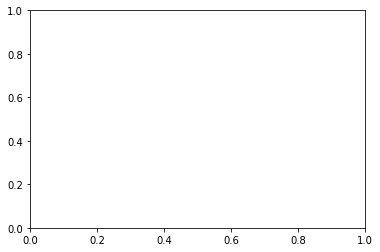

In [21]:
plt.scatter(y_test, predictions, color=['blue','green'], alpha = 0.5)
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.show();

In [22]:
# Making SVC predictions
predictions = modelSVC.predict(X_test)
predRsquared = r2_score(y_test,predictions)
rmse = sqrt(mean_squared_error(y_test, predictions))
print('R Squared: %.3f' % predRsquared)
print('RMSE: %.3f' % rmse)

R Squared: -0.292
RMSE: 0.475


ValueError: 'c' argument has 2 elements, which is not acceptable for use with 'x' with size 5250, 'y' with size 5250.

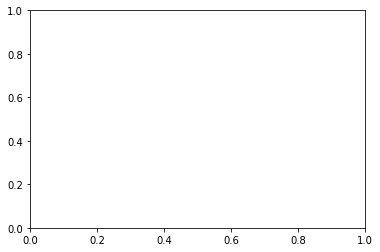

In [23]:
plt.scatter(y_test, predictions, color=['blue','green'], alpha = 0.5)
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.show();

In [24]:
# Making Decision Tree predictions
predictions = modelDT.predict(X_test)
predRsquared = r2_score(y_test,predictions)
rmse = sqrt(mean_squared_error(y_test, predictions))
print('R Squared: %.3f' % predRsquared)
print('RMSE: %.3f' % rmse)

R Squared: -0.775
RMSE: 0.557


ValueError: 'c' argument has 2 elements, which is not acceptable for use with 'x' with size 5250, 'y' with size 5250.

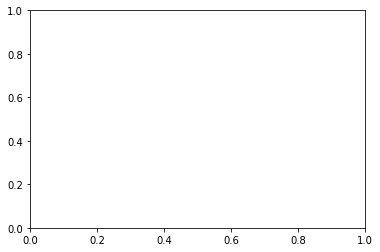

In [25]:
plt.scatter(y_test, predictions, color=['blue','green'], alpha = 0.5)
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.show();